In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torch.nn.functional as F

from helpftn import helper

import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets, transforms
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [14]:
images, labels = next(iter(trainloader))

In [15]:
from torch import nn, optim

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [16]:
model = Classifier()

# probabilities
ps = torch.exp(model(images))

print(ps.shape)

torch.Size([64, 10])


In [17]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[6],
        [6],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3]])


In [18]:
equals = top_class == labels.view(*top_class.shape)

In [25]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(accuracy.item()*100)
# print('Accuracy: %.2f%' % (accuracy.item()*100))

7.8125


In [28]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(model(images))
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        # ps = torch.exp(model(images))
        # top_p, top_class = ps.topk(1, dim=1)
        # equals = top_class == labels.view(*top_class.shape)
        # accuracy = torch.mean(equals.type(torch.FloatTensor))
        # print(accuracy.item()*100)
# use no_grad


Epoch: 1/30..  Training Loss: 0.273..  Test Loss: 0.376..  Test Accuracy: 0.873
Epoch: 2/30..  Training Loss: 0.257..  Test Loss: 0.372..  Test Accuracy: 0.876
Epoch: 3/30..  Training Loss: 0.246..  Test Loss: 0.356..  Test Accuracy: 0.882
Epoch: 4/30..  Training Loss: 0.248..  Test Loss: 0.438..  Test Accuracy: 0.867
Epoch: 5/30..  Training Loss: 0.246..  Test Loss: 0.373..  Test Accuracy: 0.879
Epoch: 6/30..  Training Loss: 0.235..  Test Loss: 0.406..  Test Accuracy: 0.876
Epoch: 7/30..  Training Loss: 0.229..  Test Loss: 0.361..  Test Accuracy: 0.879
Epoch: 8/30..  Training Loss: 0.224..  Test Loss: 0.378..  Test Accuracy: 0.881
Epoch: 9/30..  Training Loss: 0.217..  Test Loss: 0.399..  Test Accuracy: 0.877
Epoch: 10/30..  Training Loss: 0.219..  Test Loss: 0.434..  Test Accuracy: 0.875
Epoch: 11/30..  Training Loss: 0.215..  Test Loss: 0.376..  Test Accuracy: 0.889
Epoch: 12/30..  Training Loss: 0.216..  Test Loss: 0.391..  Test Accuracy: 0.874
Epoch: 13/30..  Training Loss: 0.206.

In [33]:
class NClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [34]:
model = NClassifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(model(images))
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        

        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        # ps = torch.exp(model(images))
        # top_p, top_class = ps.topk(1, dim=1)
        # equals = top_class == labels.view(*top_class.shape)
        # accuracy = torch.mean(equals.type(torch.FloatTensor))
        # print(accuracy.item()*100)
# use no_grad


Epoch: 1/30..  Training Loss: 0.604..  Test Loss: 0.459..  Test Accuracy: 0.832
Epoch: 2/30..  Training Loss: 0.485..  Test Loss: 0.445..  Test Accuracy: 0.849
Epoch: 3/30..  Training Loss: 0.454..  Test Loss: 0.414..  Test Accuracy: 0.852
Epoch: 4/30..  Training Loss: 0.428..  Test Loss: 0.411..  Test Accuracy: 0.853
Epoch: 5/30..  Training Loss: 0.424..  Test Loss: 0.402..  Test Accuracy: 0.854
Epoch: 6/30..  Training Loss: 0.408..  Test Loss: 0.423..  Test Accuracy: 0.853
Epoch: 7/30..  Training Loss: 0.407..  Test Loss: 0.398..  Test Accuracy: 0.867
Epoch: 8/30..  Training Loss: 0.402..  Test Loss: 0.399..  Test Accuracy: 0.859
Epoch: 9/30..  Training Loss: 0.394..  Test Loss: 0.397..  Test Accuracy: 0.858
Epoch: 10/30..  Training Loss: 0.393..  Test Loss: 0.396..  Test Accuracy: 0.860
Epoch: 11/30..  Training Loss: 0.390..  Test Loss: 0.390..  Test Accuracy: 0.866
Epoch: 12/30..  Training Loss: 0.385..  Test Loss: 0.382..  Test Accuracy: 0.866
Epoch: 13/30..  Training Loss: 0.376.

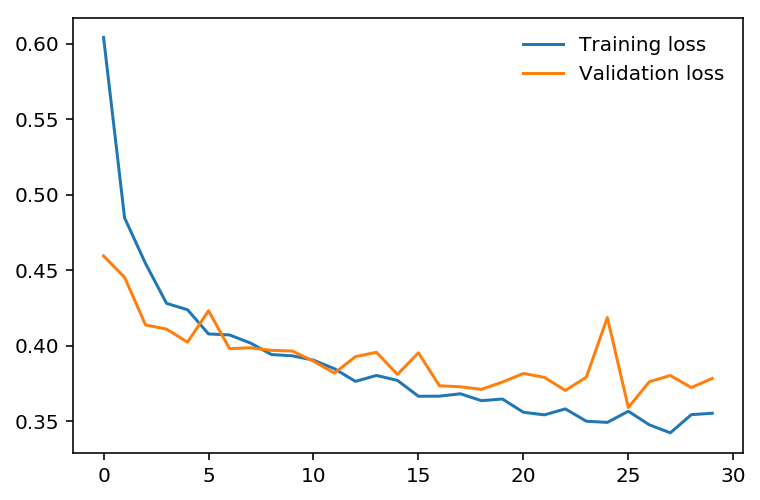

In [35]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Inference 

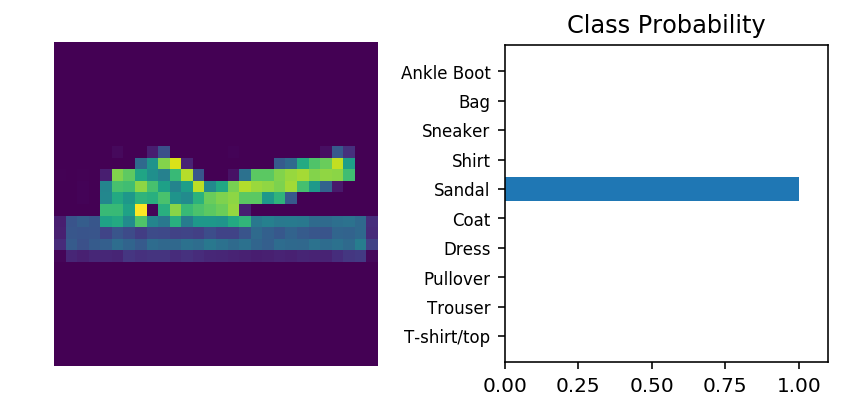

In [36]:
# Import helper module (should be in the repo)
from helpftn import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')